# HDP-base spell-sound analyzer
# developed by Kow Kuroda (kow.kuroda@gmail.com)
# History
2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした
2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化
2024/09/06 term の階層クラスタリングを実装

In [450]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [451]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [452]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [453]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [454]:
## Cython を使うかどうか
use_Cython = True
if use_Cython:
    %load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [455]:
## term settings
term_classes        = [ 'spell', 'sound' ]
term_class          = term_classes[0]
ngram_is_inclusive  = True
inclusion_degree    = None

## doc settings
max_doc_size        = 11
min_doc_size        =  3
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"

## term setting
term_is_skippy      = True
n_for_ngram         = 5
max_gap_ratio       = 1.0
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"term_class: {term_class}")
print(f"term_is_skippy: {term_is_skippy}")
print(f"max_gap_size: {max_gap_size}")
print(f"n_for_ngram: {n_for_ngram}")

## symbols
gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if term_class == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")
## define term_type
if term_class == 'spell':
    if term_is_skippy:
        term_type = f"sp_skippy{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if term_is_skippy:
        term_type = f"sn_skippy{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
## check
print(f"term_type: {term_type}")

max_doc_size: 11
min_doc_size: 3
term_class: spell
term_is_skippy: True
max_gap_size: 11
n_for_ngram: 5
accent_status: 
term_type: sp_skippy5gram


In [456]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]
## check
target_lang_key  = target_lang_keys[11]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: es_ES
target lang: Spanish (Spain) [es_ES]
target_class: 


In [457]:
## LDA/HDP
apply_term_filtering = True
## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
term_minfreq       = 2
min_bot_size       = min_doc_size # 3
abuse_threshold    = 0.05 # larger value selects shorter units, smaller value selects longer units

# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120

# saving output
save_LDAvis          = False
save_topic_structure = False

# hierarchical clustering
hc_sampling_rate = 0.01

In [458]:
## sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 5000
second_sampling          = False
second_sampling_rate     = 0.7

In [459]:
## set target files
import glob
data_dir1     = "data/open-dict-ipa/data1"
data_dir2     = "data/open-dict-ipa/data1a"
data_dir3     = "data/wn3"
data_dir4     = "data/irish"
target_files  = glob.glob(f"{data_dir1}/*")
target_files2 = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3 = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4 = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/irish/word-irish-adjectives-spell.csv',
 'data/irish/word-irish-noun-phrases-spell.csv',
 'data/irish/word-irish-nouns-spell.csv',
 'data/irish/word-irish-possessives-spell.csv',
 'data/irish/word-irish-prepositions-spell.csv',
 'data/irish/word-irish-verbs-spell.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 '

In [460]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
if target_lang_key == "ir":
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']

##
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/open-dict-ipa/data1/es_ES.csv.gz


,spell,sound
342319,fumigarías,fumiɣaˈɾias
28860,aheche,aetʃe
416225,metida,metiða
466750,prenotabais,pɾenotaβais
449148,peptonas,peptonas
334627,fingirían,fiŋxiˈɾian
413088,melgar,melgaɾ
136335,consistiré,konsistiˈɾe
436717,opacidades,opaθiðaðes
65884,arrebozaréis,areβoθaˈɾeis


In [461]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                 spell          sound
291048     #envegaste#    #embeɣaste#
533818    #secretease#   #sekɾetease#
240656   #embotijados#  #embotixaðos#
360120     #hombradía#     #ombɾaðia#
435426     #ofrecimos#    #ofɾeθimos#
...                ...            ...
581554        #unalbo#       #unalβo#
31676   #alacrancillo#  #alakɾanθiʎo#
589063    #vibratoria#   #biβɾatoɾja#
241050    #embrazamos#   #embɾaθamos#
1046     #abarraganad#   #aβaraɣanað#

[5000 rows x 2 columns]


In [462]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
291048,#envegaste#,#embeɣaste#,"[#, e, n, v, e, g, a, s, t, e, #]",11,0,0,"[#, e, m, b, e, ɣ, a, s, t, e, #]",11
533818,#secretease#,#sekɾetease#,"[#, s, e, c, r, e, t, e, a, s, e, #]",12,0,0,"[#, s, e, k, ɾ, e, t, e, a, s, e, #]",12
240656,#embotijados#,#embotixaðos#,"[#, e, m, b, o, t, i, j, a, d, o, s, #]",13,0,0,"[#, e, m, b, o, t, i, x, a, ð, o, s, #]",13
360120,#hombradía#,#ombɾaðia#,"[#, h, o, m, b, r, a, d, í, a, #]",11,0,0,"[#, o, m, b, ɾ, a, ð, i, a, #]",10
435426,#ofrecimos#,#ofɾeθimos#,"[#, o, f, r, e, c, i, m, o, s, #]",11,0,0,"[#, o, f, ɾ, e, θ, i, m, o, s, #]",11
...,...,...,...,...,...,...,...,...
581554,#unalbo#,#unalβo#,"[#, u, n, a, l, b, o, #]",8,0,0,"[#, u, n, a, l, β, o, #]",8
31676,#alacrancillo#,#alakɾanθiʎo#,"[#, a, l, a, c, r, a, n, c, i, l, l, o, #]",14,0,0,"[#, a, l, a, k, ɾ, a, n, θ, i, ʎ, o, #]",13
589063,#vibratoria#,#biβɾatoɾja#,"[#, v, i, b, r, a, t, o, r, i, a, #]",12,0,0,"[#, b, i, β, ɾ, a, t, o, ɾ, j, a, #]",12
241050,#embrazamos#,#embɾaθamos#,"[#, e, m, b, r, a, z, a, m, o, s, #]",12,0,0,"[#, e, m, b, ɾ, a, θ, a, m, o, s, #]",12


In [463]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sp_skippy5gram


,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
291048,#envegaste#,#embeɣaste#,"[#, e, n, v, e, g, a, s, t, e, #]",11,0,0,"[#, e, m, b, e, ɣ, a, s, t, e, #]",11
360120,#hombradía#,#ombɾaðia#,"[#, h, o, m, b, r, a, d, í, a, #]",11,0,0,"[#, o, m, b, ɾ, a, ð, i, a, #]",10
435426,#ofrecimos#,#ofɾeθimos#,"[#, o, f, r, e, c, i, m, o, s, #]",11,0,0,"[#, o, f, ɾ, e, θ, i, m, o, s, #]",11
489479,#recobren#,#rekoβɾen#,"[#, r, e, c, o, b, r, e, n, #]",10,0,0,"[#, r, e, k, o, β, ɾ, e, n, #]",10
527614,#rutilemos#,#rutilemos#,"[#, r, u, t, i, l, e, m, o, s, #]",11,0,0,"[#, r, u, t, i, l, e, m, o, s, #]",11
...,...,...,...,...,...,...,...,...
545581,#solfearas#,#solfeaɾas#,"[#, s, o, l, f, e, a, r, a, s, #]",11,0,0,"[#, s, o, l, f, e, a, ɾ, a, s, #]",11
363998,#idolatras#,#iðolatɾas#,"[#, i, d, o, l, a, t, r, a, s, #]",11,0,0,"[#, i, ð, o, l, a, t, ɾ, a, s, #]",11
415441,#meros#,#meɾos#,"[#, m, e, r, o, s, #]",7,0,0,"[#, m, e, ɾ, o, s, #]",7
432294,#nudillo#,#nuðiʎo#,"[#, n, u, d, i, l, l, o, #]",9,0,0,"[#, n, u, ð, i, ʎ, o, #]",8


In [464]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

1850

In [465]:
## generic function for n-gram generation
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}skippy{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}skippy{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

# Spell

In [466]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
291048    [#e, en, nv, ve, eg, ga, as, st, te, e#, #, e,...
360120    [#h, ho, om, mb, br, ra, ad, dí, ía, a#, #, h,...
435426    [#o, of, fr, re, ec, ci, im, mo, os, s#, #, o,...
489479    [#r, re, ec, co, ob, br, re, en, n#, #, r, e, ...
527614    [#r, ru, ut, ti, il, le, em, mo, os, s#, #, r,...
                                ...                        
545581    [#s, so, ol, lf, fe, ea, ar, ra, as, s#, #, s,...
363998    [#i, id, do, ol, la, at, tr, ra, as, s#, #, i,...
415441        [#m, me, er, ro, os, s#, #, m, e, r, o, s, #]
432294    [#n, nu, ud, di, il, ll, lo, o#, #, n, u, d, i...
581554    [#u, un, na, al, lb, bo, o#, #, u, n, a, l, b,...
Name: sp_2gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [467]:
## frequencies of 2grams
ngram_is_skippy = False
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('s#', 642),
 ('ar', 566),
 ('as', 374),
 ('ra', 311),
 ('#a', 307),
 ('a#', 299),
 ('re', 293),
 ('es', 280),
 ('n#', 251),
 ('en', 241),
 ('an', 227),
 ('#e', 202),
 ('os', 199),
 ('o#', 198),
 ('la', 196),
 ('ad', 187),
 ('ta', 182),
 ('is', 176),
 ('e#', 175),
 ('ca', 173),
 ('er', 156),
 ('#r', 154),
 ('#c', 150),
 ('al', 142),
 ('te', 141),
 ('ba', 140),
 ('se', 140),
 ('#p', 136),
 ('ab', 135),
 ('ea', 131)]

In [468]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
291048    [#en, env, nve, veg, ega, gas, ast, ste, te#, ...
360120    [#ho, hom, omb, mbr, bra, rad, adí, día, ía#, ...
435426    [#of, ofr, fre, rec, eci, cim, imo, mos, os#, ...
489479    [#re, rec, eco, cob, obr, bre, ren, en#, #r, r...
527614    [#ru, rut, uti, til, ile, lem, emo, mos, os#, ...
                                ...                        
545581    [#so, sol, olf, lfe, fea, ear, ara, ras, as#, ...
363998    [#id, ido, dol, ola, lat, atr, tra, ras, as#, ...
415441    [#me, mer, ero, ros, os#, #m, me, er, ro, os, ...
432294    [#nu, nud, udi, dil, ill, llo, lo#, #n, nu, ud...
581554    [#un, una, nal, alb, lbo, bo#, #u, un, na, al,...
Name: sp_3gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [469]:
## frequencies of 3grams
ngram_is_skippy = False
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('as#', 219),
 ('os#', 145),
 ('is#', 136),
 ('es#', 120),
 ('#re', 108),
 ('ara', 106),
 ('an#', 99),
 ('aba', 97),
 ('#en', 93),
 ('are', 83),
 ('ará', 81),
 ('ase', 76),
 ('#de', 72),
 ('en#', 69),
 ('ada', 63),
 ('ear', 62),
 ('mos', 60),
 ('ado', 59),
 ('ra#', 58),
 ('do#', 57),
 ('#co', 57),
 ('ras', 56),
 ('res', 54),
 ('tar', 53),
 ('da#', 53),
 ('des', 52),
 ('éis', 51),
 ('car', 49),
 ('lar', 49),
 ('#es', 49)]

In [470]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
291048    [#env, enve, nveg, vega, egas, gast, aste, ste...
360120    [#hom, homb, ombr, mbra, brad, radí, adía, día...
435426    [#ofr, ofre, frec, reci, ecim, cimo, imos, mos...
489479    [#rec, reco, ecob, cobr, obre, bren, ren#, #re...
527614    [#rut, ruti, util, tile, ilem, lemo, emos, mos...
                                ...                        
545581    [#sol, solf, olfe, lfea, fear, eara, aras, ras...
363998    [#ido, idol, dola, olat, latr, atra, tras, ras...
415441    [#mer, mero, eros, ros#, #me, mer, ero, ros, o...
432294    [#nud, nudi, udil, dill, illo, llo#, #nu, nud,...
581554    [#una, unal, nalb, albo, lbo#, #un, una, nal, ...
Name: sp_4gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [471]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


291048    [#enve, enveg, nvega, vegas, egast, gaste, ast...
360120    [#homb, hombr, ombra, mbrad, bradí, radía, adí...
435426    [#ofre, ofrec, freci, recim, ecimo, cimos, imo...
489479    [#reco, recob, ecobr, cobre, obren, bren#, #re...
527614    [#ruti, rutil, utile, tilem, ilemo, lemos, emo...
                                ...                        
545581    [#solf, solfe, olfea, lfear, feara, earas, ara...
363998    [#idol, idola, dolat, olatr, latra, atras, tra...
415441    [#mero, meros, eros#, #mer, mero, eros, ros#, ...
432294    [#nudi, nudil, udill, dillo, illo#, #nud, nudi...
581554    [#unal, unalb, nalbo, albo#, #una, unal, nalb,...
Name: sp_5gram, Length: 1850, dtype: object


In [472]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy2gram
min_size: 1
supplement_var: sp_1gram
291048    [#e, #…n, #…v, #…e, #…g, #…a, #…s, #…t, #…e, #...
360120    [#h, #…o, #…m, #…b, #…r, #…a, #…d, #…í, #…a, #...
435426    [#o, #…f, #…r, #…e, #…c, #…i, #…m, #…o, #…s, #...
489479    [#r, #…e, #…c, #…o, #…b, #…r, #…e, #…n, #…#, r...
527614    [#r, #…u, #…t, #…i, #…l, #…e, #…m, #…o, #…s, #...
                                ...                        
545581    [#s, #…o, #…l, #…f, #…e, #…a, #…r, #…a, #…s, #...
363998    [#i, #…d, #…o, #…l, #…a, #…t, #…r, #…a, #…s, #...
415441    [#m, #…e, #…r, #…o, #…s, #…#, me, m…r, m…o, m…...
432294    [#n, #…u, #…d, #…i, #…l, #…l, #…o, #…#, nu, n…...
581554    [#u, #…n, #…a, #…l, #…b, #…o, #…#, un, u…a, u…...
Name: sp_skippy2gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [473]:
## frequencies of skippy 2grams
ngram_is_skippy = True
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('a…#', 2151),
 ('#…a', 2143),
 ('#…#', 1850),
 ('e…#', 1356),
 ('#…e', 1329),
 ('r…#', 1319),
 ('#…r', 1225),
 ('a…a', 1186),
 ('#…s', 1133),
 ('#…o', 923),
 ('i…#', 838),
 ('e…a', 818),
 ('#…n', 816),
 ('#…i', 794),
 ('o…#', 754),
 ('a…s', 688),
 ('a…e', 666),
 ('s#', 642),
 ('r…a', 619),
 ('l…#', 619),
 ('s…#', 603),
 ('n…#', 596),
 ('#…l', 573),
 ('t…#', 569),
 ('ar', 566),
 ('c…#', 544),
 ('r…s', 530),
 ('e…s', 528),
 ('o…a', 486),
 ('#…t', 474)]

In [474]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy3gram
min_size: 1
supplement_var: sp_skippy2gram
291048    [#en, #e…v, #e…e, #e…g, #e…a, #e…s, #e…t, #e…e...
360120    [#ho, #h…m, #h…b, #h…r, #h…a, #h…d, #h…í, #h…a...
435426    [#of, #o…r, #o…e, #o…c, #o…i, #o…m, #o…o, #o…s...
489479    [#re, #r…c, #r…o, #r…b, #r…r, #r…e, #r…n, #r…#...
527614    [#ru, #r…t, #r…i, #r…l, #r…e, #r…m, #r…o, #r…s...
                                ...                        
545581    [#so, #s…l, #s…f, #s…e, #s…a, #s…r, #s…a, #s…s...
363998    [#id, #i…o, #i…l, #i…a, #i…t, #i…r, #i…a, #i…s...
415441    [#me, #m…r, #m…o, #m…s, #m…#, #…er, #…e…o, #…e...
432294    [#nu, #n…d, #n…i, #n…l, #n…l, #n…o, #n…#, #…ud...
581554    [#un, #u…a, #u…l, #u…b, #u…o, #u…#, #…na, #…n…...
Name: sp_skippy3gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [475]:
## frequencies of skippy 3grams
ngram_is_skippy = True
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…#', 1844),
 ('#…r…#', 1165),
 ('#…e…#', 1154),
 ('a…a…#', 906),
 ('#…a…a', 836),
 ('#…i…#', 794),
 ('#…o…#', 725),
 ('e…a…#', 649),
 ('#…s#', 642),
 ('#…e…a', 582),
 ('a…s#', 581),
 ('#…n…#', 565),
 ('#…l…#', 565),
 ('#…a…s', 542),
 ('#…ar', 540),
 ('ar…#', 519),
 ('#…a…e', 492),
 ('#…s…#', 491),
 ('#…r…a', 478),
 ('a…e…#', 477),
 ('#…t…#', 473),
 ('#…o…a', 457),
 ('r…a…#', 457),
 ('#…e…s', 435),
 ('a…r…#', 433),
 ('#…r…s', 430),
 ('#…i…a', 421),
 ('#…u…#', 417),
 ('r…s#', 410),
 ('e…s#', 395)]

In [476]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy4gram
min_size: 1
supplement_var: sp_skippy3gram
291048    [#env, #en…e, #en…g, #en…a, #en…s, #en…t, #en…...
360120    [#hom, #ho…b, #ho…r, #ho…a, #ho…d, #ho…í, #ho…...
435426    [#ofr, #of…e, #of…c, #of…i, #of…m, #of…o, #of…...
489479    [#rec, #re…o, #re…b, #re…r, #re…e, #re…n, #re…...
527614    [#rut, #ru…i, #ru…l, #ru…e, #ru…m, #ru…o, #ru…...
                                ...                        
545581    [#sol, #so…f, #so…e, #so…a, #so…r, #so…a, #so…...
363998    [#ido, #id…l, #id…a, #id…t, #id…r, #id…a, #id…...
415441    [#mer, #me…o, #me…s, #me…#, #m…ro, #m…r…s, #m…...
432294    [#nud, #nu…i, #nu…l, #nu…l, #nu…o, #nu…#, #n…d...
581554    [#una, #un…l, #un…b, #un…o, #un…#, #u…al, #u…a...
Name: sp_skippy4gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [477]:
## frequencies of skippy 4grams
ngram_is_skippy = True
n_now = 4
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…a…#', 602),
 ('#…ar…#', 493),
 ('#…a…s#', 482),
 ('#…e…a…#', 453),
 ('#…o…a…#', 360),
 ('#…r…s#', 354),
 ('#…e…s#', 340),
 ('#…a…e…#', 335),
 ('#…r…a…#', 334),
 ('#a…a…#', 304),
 ('#…i…a…#', 297),
 ('#…e…r…#', 271),
 ('#…n…a…#', 260),
 ('#…a…n#', 237),
 ('#…ra…#', 236),
 ('#…a…r…#', 236),
 ('#…a…a#', 234),
 ('a…ar…#', 226),
 ('#…as#', 219),
 ('#…e…e…#', 217),
 ('#…l…a…#', 214),
 ('#…a…i…#', 213),
 ('#…o…e…#', 211),
 ('#…u…a…#', 203),
 ('#…o…s#', 203),
 ('#…i…s#', 202),
 ('#a…r…#', 197),
 ('#e…a…#', 196),
 ('a…as#', 195),
 ('#…r…n#', 192)]

In [478]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy5gram
min_size: 1
supplement_var: sp_skippy4gram
291048    [#enve, #env…g, #env…a, #env…s, #env…t, #env…e...
360120    [#homb, #hom…r, #hom…a, #hom…d, #hom…í, #hom…a...
435426    [#ofre, #ofr…c, #ofr…i, #ofr…m, #ofr…o, #ofr…s...
489479    [#reco, #rec…b, #rec…r, #rec…e, #rec…n, #rec…#...
527614    [#ruti, #rut…l, #rut…e, #rut…m, #rut…o, #rut…s...
                                ...                        
545581    [#solf, #sol…e, #sol…a, #sol…r, #sol…a, #sol…s...
363998    [#idol, #ido…a, #ido…t, #ido…r, #ido…a, #ido…s...
415441    [#mero, #mer…s, #mer…#, #me…os, #me…o…#, #me…s...
432294    [#nudi, #nud…l, #nud…l, #nud…o, #nud…#, #nu…il...
581554    [#unal, #una…b, #una…o, #una…#, #un…lb, #un…l…...
Name: sp_skippy5gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [479]:
## frequencies of skippy 5grams
ngram_is_skippy = True
n_now = 5
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…as#', 160),
 ('#…ar…s#', 144),
 ('#…a…ar…#', 131),
 ('#…e…ar…#', 122),
 ('#…a…a…s#', 117),
 ('#…ar…n#', 116),
 ('#…e…os#', 101),
 ('#…o…ar…#', 101),
 ('#…e…as#', 95),
 ('#a…ar…#', 95),
 ('#…a…an#', 94),
 ('#…a…is#', 94),
 ('#…a…es#', 92),
 ('#en…a…#', 91),
 ('#a…a…a…#', 89),
 ('#…a…os#', 88),
 ('#…o…a…s#', 86),
 ('#…r…as#', 83),
 ('#…e…a…s#', 80),
 ('#…ar…a…#', 80),
 ('#re…a…#', 79),
 ('#…r…ar…#', 77),
 ('#…o…as#', 76),
 ('#…i…as#', 75),
 ('#a…a…s#', 75),
 ('#…a…e…s#', 72),
 ('#…e…a…a…#', 71),
 ('#…e…r…s#', 71),
 ('#…a…r…s#', 71),
 ('#…n…ar…#', 70)]

In [480]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1,6) ])
target_vars.extend([ f"sp_skippy{i}gram" for i in range(2,6) ])
df[target_vars]

,spell,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram
291048,#envegaste#,"[#, e, n, v, e, g, a, s, t, e, #]","[#e, en, nv, ve, eg, ga, as, st, te, e#, #, e,...","[#en, env, nve, veg, ega, gas, ast, ste, te#, ...","[#env, enve, nveg, vega, egas, gast, aste, ste...","[#enve, enveg, nvega, vegas, egast, gaste, ast...","[#e, #…n, #…v, #…e, #…g, #…a, #…s, #…t, #…e, #...","[#en, #e…v, #e…e, #e…g, #e…a, #e…s, #e…t, #e…e...","[#env, #en…e, #en…g, #en…a, #en…s, #en…t, #en…...","[#enve, #env…g, #env…a, #env…s, #env…t, #env…e..."
360120,#hombradía#,"[#, h, o, m, b, r, a, d, í, a, #]","[#h, ho, om, mb, br, ra, ad, dí, ía, a#, #, h,...","[#ho, hom, omb, mbr, bra, rad, adí, día, ía#, ...","[#hom, homb, ombr, mbra, brad, radí, adía, día...","[#homb, hombr, ombra, mbrad, bradí, radía, adí...","[#h, #…o, #…m, #…b, #…r, #…a, #…d, #…í, #…a, #...","[#ho, #h…m, #h…b, #h…r, #h…a, #h…d, #h…í, #h…a...","[#hom, #ho…b, #ho…r, #ho…a, #ho…d, #ho…í, #ho…...","[#homb, #hom…r, #hom…a, #hom…d, #hom…í, #hom…a..."
435426,#ofrecimos#,"[#, o, f, r, e, c, i, m, o, s, #]","[#o, of, fr, re, ec, ci, im, mo, os, s#, #, o,...","[#of, ofr, fre, rec, eci, cim, imo, mos, os#, ...","[#ofr, ofre, frec, reci, ecim, cimo, imos, mos...","[#ofre, ofrec, freci, recim, ecimo, cimos, imo...","[#o, #…f, #…r, #…e, #…c, #…i, #…m, #…o, #…s, #...","[#of, #o…r, #o…e, #o…c, #o…i, #o…m, #o…o, #o…s...","[#ofr, #of…e, #of…c, #of…i, #of…m, #of…o, #of…...","[#ofre, #ofr…c, #ofr…i, #ofr…m, #ofr…o, #ofr…s..."
489479,#recobren#,"[#, r, e, c, o, b, r, e, n, #]","[#r, re, ec, co, ob, br, re, en, n#, #, r, e, ...","[#re, rec, eco, cob, obr, bre, ren, en#, #r, r...","[#rec, reco, ecob, cobr, obre, bren, ren#, #re...","[#reco, recob, ecobr, cobre, obren, bren#, #re...","[#r, #…e, #…c, #…o, #…b, #…r, #…e, #…n, #…#, r...","[#re, #r…c, #r…o, #r…b, #r…r, #r…e, #r…n, #r…#...","[#rec, #re…o, #re…b, #re…r, #re…e, #re…n, #re…...","[#reco, #rec…b, #rec…r, #rec…e, #rec…n, #rec…#..."
527614,#rutilemos#,"[#, r, u, t, i, l, e, m, o, s, #]","[#r, ru, ut, ti, il, le, em, mo, os, s#, #, r,...","[#ru, rut, uti, til, ile, lem, emo, mos, os#, ...","[#rut, ruti, util, tile, ilem, lemo, emos, mos...","[#ruti, rutil, utile, tilem, ilemo, lemos, emo...","[#r, #…u, #…t, #…i, #…l, #…e, #…m, #…o, #…s, #...","[#ru, #r…t, #r…i, #r…l, #r…e, #r…m, #r…o, #r…s...","[#rut, #ru…i, #ru…l, #ru…e, #ru…m, #ru…o, #ru…...","[#ruti, #rut…l, #rut…e, #rut…m, #rut…o, #rut…s..."
...,...,...,...,...,...,...,...,...,...,...
545581,#solfearas#,"[#, s, o, l, f, e, a, r, a, s, #]","[#s, so, ol, lf, fe, ea, ar, ra, as, s#, #, s,...","[#so, sol, olf, lfe, fea, ear, ara, ras, as#, ...","[#sol, solf, olfe, lfea, fear, eara, aras, ras...","[#solf, solfe, olfea, lfear, feara, earas, ara...","[#s, #…o, #…l, #…f, #…e, #…a, #…r, #…a, #…s, #...","[#so, #s…l, #s…f, #s…e, #s…a, #s…r, #s…a, #s…s...","[#sol, #so…f, #so…e, #so…a, #so…r, #so…a, #so…...","[#solf, #sol…e, #sol…a, #sol…r, #sol…a, #sol…s..."
363998,#idolatras#,"[#, i, d, o, l, a, t, r, a, s, #]","[#i, id, do, ol, la, at, tr, ra, as, s#, #, i,...","[#id, ido, dol, ola, lat, atr, tra, ras, as#, ...","[#ido, idol, dola, olat, latr, atra, tras, ras...","[#idol, idola, dolat, olatr, latra, atras, tra...","[#i, #…d, #…o, #…l, #…a, #…t, #…r, #…a, #…s, #...","[#id, #i…o, #i…l, #i…a, #i…t, #i…r, #i…a, #i…s...","[#ido, #id…l, #id…a, #id…t, #id…r, #id…a, #id…...","[#idol, #ido…a, #ido…t, #ido…r, #ido…a, #ido…s..."
415441,#meros#,"[#, m, e, r, o, s, #]","[#m, me, er, ro, os, s#, #, m, e, r, o, s, #]","[#me, mer, ero, ros, os#, #m, me, er, ro, os, ...","[#mer, mero, eros, ros#, #me, mer, ero, ros, o...","[#mero, meros, eros#, #mer, mero, eros, ros#, ...","[#m, #…e, #…r, #…o, #…s, #…#, me, m…r, m…o, m…...","[#me, #m…r, #m…o, #m…s, #m…#, #…er, #…e…o, #…e...","[#mer, #me…o, #me…s, #me…#, #m…ro, #m…r…s, #m…...","[#mero, #mer…s, #mer…#, #me…os, #me…o…#, #me…s..."
432294,#nudillo#,"[#, n, u, d, i, l, l, o, #]","[#n, nu, ud, di, il, ll, lo, o#, #, n, u, d, i...","

# Sound

In [481]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
291048    [#e, em, mb, be, eɣ, ɣa, as, st, te, e#, #, e,...
360120    [#o, om, mb, bɾ, ɾa, að, ði, ia, a#, #, o, m, ...
435426    [#o, of, fɾ, ɾe, eθ, θi, im, mo, os, s#, #, o,...
489479    [#r, re, ek, ko, oβ, βɾ, ɾe, en, n#, #, r, e, ...
527614    [#r, ru, ut, ti, il, le, em, mo, os, s#, #, r,...
                                ...                        
545581    [#s, so, ol, lf, fe, ea, aɾ, ɾa, as, s#, #, s,...
363998    [#i, ið, ðo, ol, la, at, tɾ, ɾa, as, s#, #, i,...
415441        [#m, me, eɾ, ɾo, os, s#, #, m, e, ɾ, o, s, #]
432294    [#n, nu, uð, ði, iʎ, ʎo, o#, #, n, u, ð, i, ʎ,...
581554    [#u, un, na, al, lβ, βo, o#, #, u, n, a, l, β,...
Name: sn_2gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [482]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
291048    [#em, emb, mbe, beɣ, eɣa, ɣas, ast, ste, te#, ...
360120    [#om, omb, mbɾ, bɾa, ɾað, aði, ðia, ia#, #o, o...
435426    [#of, ofɾ, fɾe, ɾeθ, eθi, θim, imo, mos, os#, ...
489479    [#re, rek, eko, koβ, oβɾ, βɾe, ɾen, en#, #r, r...
527614    [#ru, rut, uti, til, ile, lem, emo, mos, os#, ...
                                ...                        
545581    [#so, sol, olf, lfe, fea, eaɾ, aɾa, ɾas, as#, ...
363998    [#ið, iðo, ðol, ola, lat, atɾ, tɾa, ɾas, as#, ...
415441    [#me, meɾ, eɾo, ɾos, os#, #m, me, eɾ, ɾo, os, ...
432294    [#nu, nuð, uði, ðiʎ, iʎo, ʎo#, #n, nu, uð, ði,...
581554    [#un, una, nal, alβ, lβo, βo#, #u, un, na, al,...
Name: sn_3gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [483]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
291048    [#emb, embe, mbeɣ, beɣa, eɣas, ɣast, aste, ste...
360120    [#omb, ombɾ, mbɾa, bɾað, ɾaði, aðia, ðia#, #om...
435426    [#ofɾ, ofɾe, fɾeθ, ɾeθi, eθim, θimo, imos, mos...
489479    [#rek, reko, ekoβ, koβɾ, oβɾe, βɾen, ɾen#, #re...
527614    [#rut, ruti, util, tile, ilem, lemo, emos, mos...
                                ...                        
545581    [#sol, solf, olfe, lfea, feaɾ, eaɾa, aɾas, ɾas...
363998    [#iðo, iðol, ðola, olat, latɾ, atɾa, tɾas, ɾas...
415441    [#meɾ, meɾo, eɾos, ɾos#, #me, meɾ, eɾo, ɾos, o...
432294    [#nuð, nuði, uðiʎ, ðiʎo, iʎo#, #nu, nuð, uði, ...
581554    [#una, unal, nalβ, alβo, lβo#, #un, una, nal, ...
Name: sn_4gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [484]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_5gram
min_size: 1
supplement_var: sn_4gram
291048    [#embe, embeɣ, mbeɣa, beɣas, eɣast, ɣaste, ast...
360120    [#ombɾ, ombɾa, mbɾað, bɾaði, ɾaðia, aðia#, #om...
435426    [#ofɾe, ofɾeθ, fɾeθi, ɾeθim, eθimo, θimos, imo...
489479    [#reko, rekoβ, ekoβɾ, koβɾe, oβɾen, βɾen#, #re...
527614    [#ruti, rutil, utile, tilem, ilemo, lemos, emo...
                                ...                        
545581    [#solf, solfe, olfea, lfeaɾ, feaɾa, eaɾas, aɾa...
363998    [#iðol, iðola, ðolat, olatɾ, latɾa, atɾas, tɾa...
415441    [#meɾo, meɾos, eɾos#, #meɾ, meɾo, eɾos, ɾos#, ...
432294    [#nuði, nuðiʎ, uðiʎo, ðiʎo#, #nuð, nuði, uðiʎ,...
581554    [#unal, unalβ, nalβo, alβo#, #una, unal, nalβ,...
Name: sn_5gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [485]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy2gram
min_size: 1
supplement_var: sn_1gram
291048    [#e, #…m, #…b, #…e, #…ɣ, #…a, #…s, #…t, #…e, #...
360120    [#o, #…m, #…b, #…ɾ, #…a, #…ð, #…i, #…a, #…#, o...
435426    [#o, #…f, #…ɾ, #…e, #…θ, #…i, #…m, #…o, #…s, #...
489479    [#r, #…e, #…k, #…o, #…β, #…ɾ, #…e, #…n, #…#, r...
527614    [#r, #…u, #…t, #…i, #…l, #…e, #…m, #…o, #…s, #...
                                ...                        
545581    [#s, #…o, #…l, #…f, #…e, #…a, #…ɾ, #…a, #…s, #...
363998    [#i, #…ð, #…o, #…l, #…a, #…t, #…ɾ, #…a, #…s, #...
415441    [#m, #…e, #…ɾ, #…o, #…s, #…#, me, m…ɾ, m…o, m…...
432294    [#n, #…u, #…ð, #…i, #…ʎ, #…o, #…#, nu, n…ð, n…...
581554    [#u, #…n, #…a, #…l, #…β, #…o, #…#, un, u…a, u…...
Name: sn_skippy2gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [486]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy3gram
min_size: 1
supplement_var: sn_skippy2gram
291048    [#em, #e…b, #e…e, #e…ɣ, #e…a, #e…s, #e…t, #e…e...
360120    [#om, #o…b, #o…ɾ, #o…a, #o…ð, #o…i, #o…a, #o…#...
435426    [#of, #o…ɾ, #o…e, #o…θ, #o…i, #o…m, #o…o, #o…s...
489479    [#re, #r…k, #r…o, #r…β, #r…ɾ, #r…e, #r…n, #r…#...
527614    [#ru, #r…t, #r…i, #r…l, #r…e, #r…m, #r…o, #r…s...
                                ...                        
545581    [#so, #s…l, #s…f, #s…e, #s…a, #s…ɾ, #s…a, #s…s...
363998    [#ið, #i…o, #i…l, #i…a, #i…t, #i…ɾ, #i…a, #i…s...
415441    [#me, #m…ɾ, #m…o, #m…s, #m…#, #…eɾ, #…e…o, #…e...
432294    [#nu, #n…ð, #n…i, #n…ʎ, #n…o, #n…#, #…uð, #…u…...
581554    [#un, #u…a, #u…l, #u…β, #u…o, #u…#, #…na, #…n…...
Name: sn_skippy3gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [487]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy4gram
min_size: 1
supplement_var: sn_skippy3gram
291048    [#emb, #em…e, #em…ɣ, #em…a, #em…s, #em…t, #em…...
360120    [#omb, #om…ɾ, #om…a, #om…ð, #om…i, #om…a, #om…...
435426    [#ofɾ, #of…e, #of…θ, #of…i, #of…m, #of…o, #of…...
489479    [#rek, #re…o, #re…β, #re…ɾ, #re…e, #re…n, #re…...
527614    [#rut, #ru…i, #ru…l, #ru…e, #ru…m, #ru…o, #ru…...
                                ...                        
545581    [#sol, #so…f, #so…e, #so…a, #so…ɾ, #so…a, #so…...
363998    [#iðo, #ið…l, #ið…a, #ið…t, #ið…ɾ, #ið…a, #ið…...
415441    [#meɾ, #me…o, #me…s, #me…#, #m…ɾo, #m…ɾ…s, #m…...
432294    [#nuð, #nu…i, #nu…ʎ, #nu…o, #nu…#, #n…ði, #n…ð...
581554    [#una, #un…l, #un…β, #un…o, #un…#, #u…al, #u…a...
Name: sn_skippy4gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [488]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy5gram
min_size: 1
supplement_var: sn_skippy4gram
291048    [#embe, #emb…ɣ, #emb…a, #emb…s, #emb…t, #emb…e...
360120    [#ombɾ, #omb…a, #omb…ð, #omb…i, #omb…a, #omb…#...
435426    [#ofɾe, #ofɾ…θ, #ofɾ…i, #ofɾ…m, #ofɾ…o, #ofɾ…s...
489479    [#reko, #rek…β, #rek…ɾ, #rek…e, #rek…n, #rek…#...
527614    [#ruti, #rut…l, #rut…e, #rut…m, #rut…o, #rut…s...
                                ...                        
545581    [#solf, #sol…e, #sol…a, #sol…ɾ, #sol…a, #sol…s...
363998    [#iðol, #iðo…a, #iðo…t, #iðo…ɾ, #iðo…a, #iðo…s...
415441    [#meɾo, #meɾ…s, #meɾ…#, #me…os, #me…o…#, #me…s...
432294    [#nuði, #nuð…ʎ, #nuð…o, #nuð…#, #nu…iʎ, #nu…i…...
581554    [#unal, #una…β, #una…o, #una…#, #un…lβ, #un…l…...
Name: sn_skippy5gram, Length: 1850, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [489]:
## check result
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if term_class == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

,spell,sound,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram,sn_5gram,sn_skippy5gram
291048,#envegaste#,#embeɣaste#,"[#, e, n, v, e, g, a, s, t, e, #]","[#e, en, nv, ve, eg, ga, as, st, te, e#, #, e,...","[#en, env, nve, veg, ega, gas, ast, ste, te#, ...","[#env, enve, nveg, vega, egas, gast, aste, ste...","[#enve, enveg, nvega, vegas, egast, gaste, ast...","[#e, #…n, #…v, #…e, #…g, #…a, #…s, #…t, #…e, #...","[#en, #e…v, #e…e, #e…g, #e…a, #e…s, #e…t, #e…e...","[#env, #en…e, #en…g, #en…a, #en…s, #en…t, #en…...","[#enve, #env…g, #env…a, #env…s, #env…t, #env…e...","[#embe, embeɣ, mbeɣa, beɣas, eɣast, ɣaste, ast...","[#embe, #emb…ɣ, #emb…a, #emb…s, #emb…t, #emb…e..."
360120,#hombradía#,#ombɾaðia#,"[#, h, o, m, b, r, a, d, í, a, #]","[#h, ho, om, mb, br, ra, ad, dí, ía, a#, #, h,...","[#ho, hom, omb, mbr, bra, rad, adí, día, ía#, ...","[#hom, homb, ombr, mbra, brad, radí, adía, día...","[#homb, hombr, ombra, mbrad, bradí, radía, adí...","[#h, #…o, #…m, #…b, #…r, #…a, #…d, #…í, #…a, #...","[#ho, #h…m, #h…b, #h…r, #h…a, #h…d, #h…í, #h…a...","[#hom, #ho…b, #ho…r, #ho…a, #ho…d, #ho…í, #ho…...","[#homb, #hom…r, #hom…a, #hom…d, #hom…í, #hom…a...","[#ombɾ, ombɾa, mbɾað, bɾaði, ɾaðia, aðia#, #om...","[#ombɾ, #omb…a, #omb…ð, #omb…i, #omb…a, #omb…#..."
435426,#ofrecimos#,#ofɾeθimos#,"[#, o, f, r, e, c, i, m, o, s, #]","[#o, of, fr, re, ec, ci, im, mo, os, s#, #, o,...","[#of, ofr, fre, rec, eci, cim, imo, mos, os#, ...","[#ofr, ofre, frec, reci, ecim, cimo, imos, mos...","[#ofre, ofrec, freci, recim, ecimo, cimos, imo...","[#o, #…f, #…r, #…e, #…c, #…i, #…m, #…o, #…s, #...","[#of, #o…r, #o…e, #o…c, #o…i, #o…m, #o…o, #o…s...","[#ofr, #of…e, #of…c, #of…i, #of…m, #of…o, #of…...","[#ofre, #ofr…c, #ofr…i, #ofr…m, #ofr…o, #ofr…s...","[#ofɾe, ofɾeθ, fɾeθi, ɾeθim, eθimo, θimos, imo...","[#ofɾe, #ofɾ…θ, #ofɾ…i, #ofɾ…m, #ofɾ…o, #ofɾ…s..."
489479,#recobren#,#rekoβɾen#,"[#, r, e, c, o, b, r, e, n, #]","[#r, re, ec, co, ob, br, re, en, n#, #, r, e, ...","[#re, rec, eco, cob, obr, bre, ren, en#, #r, r...","[#rec, reco, ecob, cobr, obre, bren, ren#, #re...","[#reco, recob, ecobr, cobre, obren, bren#, #re...","[#r, #…e, #…c, #…o, #…b, #…r, #…e, #…n, #…#, r...","[#re, #r…c, #r…o, #r…b, #r…r, #r…e, #r…n, #r…#...","[#rec, #re…o, #re…b, #re…r, #re…e, #re…n, #re…...","[#reco, #rec…b, #rec…r, #rec…e, #rec…n, #rec…#...","[#reko, rekoβ, ekoβɾ, koβɾe, oβɾen, βɾen#, #re...","[#reko, #rek…β, #rek…ɾ, #rek…e, #rek…n, #rek…#..."
527614,#rutilemos#,#rutilemos#,"[#, r, u, t, i, l, e, m, o, s, #]","[#r, ru, ut, ti, il, le, em, mo, os, s#, #, r,...","[#ru, rut, uti, til, ile, lem, emo, mos, os#, ...","[#rut, ruti, util, tile, ilem, lemo, emos, mos...","[#ruti, rutil, utile, tilem, ilemo, lemos, emo...","[#r, #…u, #…t, #…i, #…l, #…e, #…m, #…o, #…s, #...","[#ru, #r…t, #r…i, #r…l, #r…e, #r…m, #r…o, #r…s...","[#rut, #ru…i, #ru…l, #ru…e, #ru…m, #ru…o, #ru…...","[#ruti, #rut…l, #rut…e, #rut…m, #rut…o, #rut…s...","[#ruti, rutil, utile, tilem, ilemo, lemos, emo...","[#ruti, #rut…l, #rut…e, #rut…m, #rut…o, #rut…s..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
545581,#solfearas#,#solfeaɾas#,"[#, s, o, l, f, e, a, r, a, s, #]","[#s, so, ol, lf, fe, ea, ar, ra, as, s#, #, s,...","[#so, sol, olf, lfe, fea, ear, ara, ras, as#, ...","[#sol, solf, olfe, lfea, fear, eara, aras, ras...","[#solf, solfe, olfea, lfear, feara, earas, ara...","[#s, #…o, #…l, #…f, #…e, #…a, #…r, #…a, #…s, #...","[#so, #s…l, #s…f, #s…e, #s…a, #s…r, #s…a, #s…s...","[#sol, #so…f, #so…e, #so…a, #so…r, #so…a, #so…...","[#solf, #sol…e, #sol…a, #sol…r, #sol…a, #sol…s...","[#solf, solfe, olfea, lfeaɾ, feaɾa, eaɾas, aɾa...","[#solf, #sol…e, #sol…a, #sol…ɾ, #sol…a, #sol…s..."
363998,#idolatras#,#iðolatɾas#,"[#, i, d, o, l, a, t, r, a, s, #]","[#i, id, do, ol, la, at, tr, ra, as, s#, #, i,...","[#id, ido, dol, ola, lat, atr, tra, ras, as#, ...","[#ido, idol, dola, olat, latr, atra, tras, ras...","[#idol, idola, dolat, olatr, latra, atras, tra...","[#i, #…d, 

# Analysis

In [490]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [491]:
## term の階層クラスタリングの関数
def hc_clustering_terms_from_hdp(hdp_model, diction, n_topics: int, lowest_density: float, gap_mark: str, min_length: int = 2, max_length: int = n_for_ngram, sampling_rate: float = 0.3, linkage_method: str = 'ward', use_CJK: bool = False, check: bool = False):
    """produce hierarchical clustering of terms from a given HDP"""
    import pandas as pd
    import random
    ## HDP model を LDP model に変換し encoding を得る
    lda = hdp_model.suggested_lda_model()
    ## get_term_topics(..) では　minimum_probability = 0 としても
    ## probabaly = 0 の topic IDs が得られないので，sparse encoding しか得られない
    term_enc = \
        { term : { x[0] : x[1] for x in lda.get_term_topics(tid, minimum_probability = 0) } for tid, term in diction.items() }
    ## check
    if check:
        pp.pprint(random.sample(term_enc.items(), 3))
        print(f"Number of terms: {len(term_enc)}")

    ## pandas を使って sparse_enc を full enc に変換
    term_enc_df = pd.DataFrame.from_dict( { k : pd.Series(v) for k, v in term_enc.items()} )
    term_enc_df = term_enc_df.fillna(0)   # 上で生じたNaN を0に変換
    term_enc_df = term_enc_df.transpose() # データを転地
    if check:
        term_enc_df
    
    ## filtering terms: density で filtering
    size0 = len(term_enc_df)
    term_enc_df_density_filtered = term_enc_df[ term_enc_df.sum(axis = 1) >= lowest_density ]
    size1 = len(term_enc_df_density_filtered)
    print(f"{size1} rows remain after density filtering, discarding {size0 - size1} rows")
    
    ## term length で filtering
    term_enc_df = term_enc_df_density_filtered
    len_filter = [ len(x.replace(gap_mark, "")) >= min_length and len(x.replace(gap_mark, "")) <= max_length for x in term_enc_df.index ]
    term_enc_df = term_enc_df[len_filter]
    size2 = len(term_enc_df)
    print(f"{size2} rows remain after size filtering, discarding {size1 - size2} rows")
    ## sampling term_enc_df for hc
    sampled_term_enc_df = term_enc_df.sample(round(len(term_enc_df) * sampling_rate))
    size3 = len(sampled_term_enc_df)
    print(f"{size3} rows remain after size filtering, discarding {size2 - size3} rows")
    if check:
        sampled_term_enc_df
    
    ## term の階層クラスタリングの実行
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram, linkage

    ## 日本語表示のための設定
    plt.rcParams['axes.unicode_minus'] = False   #These two lines need to be set manually
    if use_CJK:
        plt.rcParams["font.family"] = "Hiragino Sans" # Windows/Linux では別のフォントを指定
    else:
        plt.rcParams["font.family"] = "Lucida Sans Unicode"

    ## 描画サイズの指定
    plt.figure(figsize = (6, round(10 * len(sampled_term_enc_df) * 0.018)))

    ## 距離行列の構築
    #linkage_methods = [ 'centroid', 'median', 'ward' ]
    #linkage_method  = linkage_methods[-1]
    term_linkage    = linkage(sampled_term_enc_df, method = linkage_method, metric = 'euclidean')

    ## 事例ラベルの生成
    max_term_length = max([ len(x) for x in list(sampled_term_enc_df.index)])
    label_vals = [ x[:max_term_length] for x in list(sampled_term_enc_df.index) ] # truncate doc keys
    
    ## 樹状分岐図の作成
    dendrogram(term_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

    ## 題の指定
    term_df_size = len(sampled_term_enc_df)
    sampling_rate = f"{100 * sampling_rate:.2f}"
    title_header = f"Hierarchical clustering of {term_df_size} terms of lengths {min_length}-{max_length} (= {sampling_rate}% sample) via\n"
    title_body = f"LDA converted from HDP (max_n_topics: {n_topics}); term: {term_type})"
    title_val = title_header + title_body
    plt.title(title_val)
    #
    plt.show()

In [492]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_70355/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(549, '#llano#'),
 (1294, '#lactaban#'),
 (1428, '#matalotes#'),
 (699, '#recubrí#'),
 (380, '#fabulabas#'),
 (1760, '#remostos#'),
 (239, '#desgajáis#'),
 (1089, '#bolseado#'),
 (1311, '#acoplase#'),
 (1636, '#cercioras#')]

In [493]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_skippy4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially
import random
random.sample(bots, 1)

[['#bubó',
  '#bub…n',
  '#bub…i',
  '#bub…c',
  '#bub…o',
  '#bub…s',
  '#bub…#',
  '#bu…ón',
  '#bu…ó…i',
  '#bu…ó…c',
  '#bu…ó…o',
  '#bu…ó…s',
  '#bu…ó…#',
  '#bu…ni',
  '#bu…n…c',
  '#bu…n…o',
  '#bu…n…s',
  '#bu…n…#',
  '#bu…ic',
  '#bu…i…o',
  '#bu…i…s',
  '#bu…i…#',
  '#bu…co',
  '#bu…c…s',
  '#bu…c…#',
  '#bu…os',
  '#bu…o…#',
  '#bu…s#',
  '#b…bón',
  '#b…bó…i',
  '#b…bó…c',
  '#b…bó…o',
  '#b…bó…s',
  '#b…bó…#',
  '#b…b…ni',
  '#b…b…n…c',
  '#b…b…n…o',
  '#b…b…n…s',
  '#b…b…n…#',
  '#b…b…ic',
  '#b…b…i…o',
  '#b…b…i…s',
  '#b…b…i…#',
  '#b…b…co',
  '#b…b…c…s',
  '#b…b…c…#',
  '#b…b…os',
  '#b…b…o…#',
  '#b…b…s#',
  '#b…óni',
  '#b…ón…c',
  '#b…ón…o',
  '#b…ón…s',
  '#b…ón…#',
  '#b…ó…ic',
  '#b…ó…i…o',
  '#b…ó…i…s',
  '#b…ó…i…#',
  '#b…ó…co',
  '#b…ó…c…s',
  '#b…ó…c…#',
  '#b…ó…os',
  '#b…ó…o…#',
  '#b…ó…s#',
  '#b…nic',
  '#b…ni…o',
  '#b…ni…s',
  '#b…ni…#',
  '#b…n…co',
  '#b…n…c…s',
  '#b…n…c…#',
  '#b…n…os',
  '#b…n…o…#',
  '#b…n…s#',
  '#b…ico',
  '#b…ic…s',
  '#b…ic…#'

In [494]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_minfreq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)
## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<467615 unique tokens: ['#', '#e', '#en', '#env', '#enve']...>
term filtering applied
Dictionary<100000 unique tokens: ['#env', '#env…#', '#env…a', '#env…e', '#env…g']...>


In [495]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [496]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [497]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [498]:
## topic investigation
import numpy as np
import HDP_helper
reload_module = False
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * e…os# + 0.0 * #…e…os + 0.0 * #…c…o + 0.0 * #…e…os# + 0.0 * c…o…# + 0.0 * o…o…# + 0.0 * #c…r + 0.0 * #c…r…# + 0.0 * #…o…o…# + 0.0 * #c…a…# + 0.0 * #…ro…# + 0.0 * co…# + 0.0 * p…o + 0.0 * #…r…o…# + 0.0 * #…l…o + 0.0 * #c…s + 0.0 * #…n…o…# + 0.0 * n…o…# + 0.0 * co…a + 0.0 * #p…a
nonzero count:  471
	0.9990: #desalmara#
	0.9989: #escalando#
	0.9988: #maceremos#
	0.9988: #colorares#
	0.9988: #porreados#
	0.9988: #recularon#
	0.9988: #huroneros#
	0.9988: #enarcaron#
	0.9987: #escarnada#
	0.9987: #coladores#
	0.9987: #latiremos#
	0.9987: #coloreada#
	0.9986: #torreemos#
	0.9986: #troncados#
	0.9986: #reclutara#
topic_id 1: 0.0 * a…e…s + 0.0 * a…e…s# + 0.0 * a…ad + 0.0 * #…a…d…# + 0.0 * #…r…d + 0.0 * #…a…is + 0.0 * an…a + 0.0 * a…a…o + 0.0 * #…a…is# + 0.0 * #…aba + 0.0 * a…os + 0.0 * a…ad…# + 0.0 * f…a + 0.0 * #…r…d…# + 0.0 * #…a…e…s + 0.0 * #a…d + 0.0 * a…os# + 0.0 * i…d + 0.0 * h…a + 0.0 * o…e…s
nonzero count:  434
	0.9988: #barraseis#
	0.9988: #endonabas#
	0.9987: #bachead

In [499]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

11263 rows remain after density filtering, discarding 88737 rows
10804 rows remain after size filtering, discarding 459 rows
108 rows remain after size filtering, discarding 10696 rows


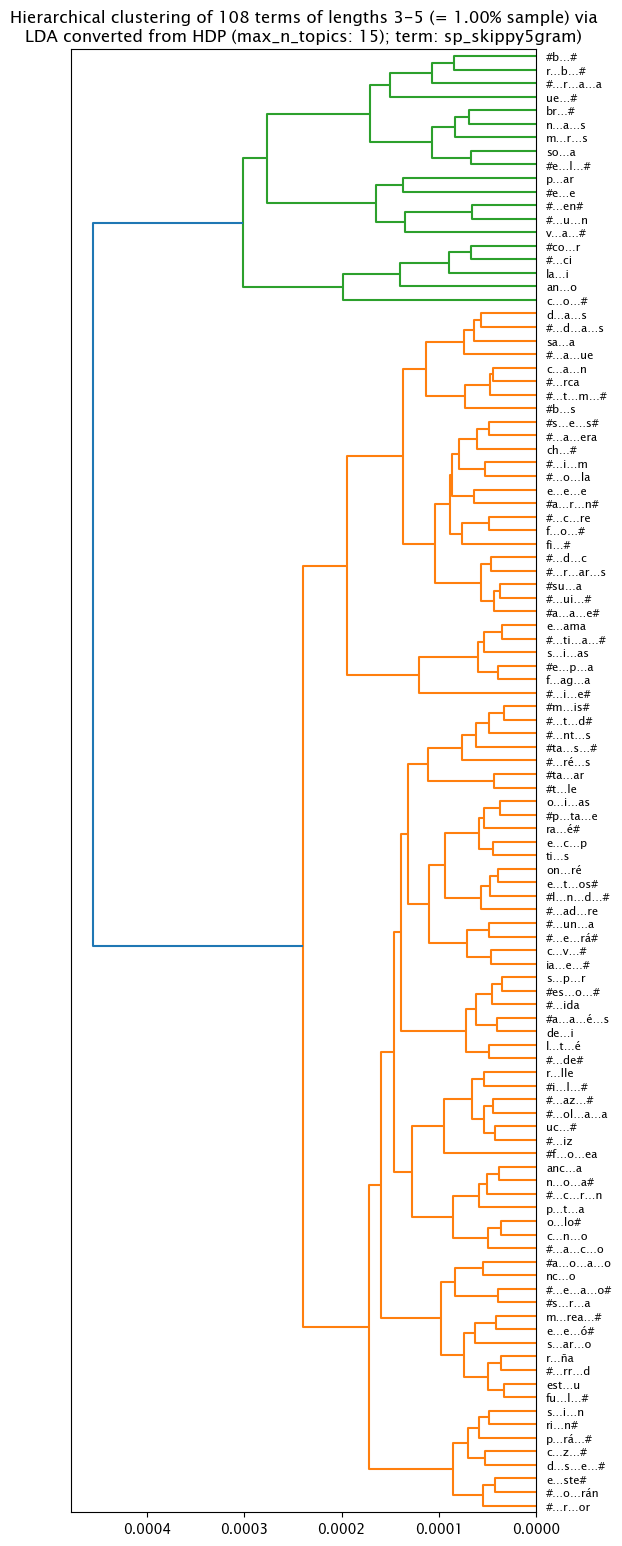

In [500]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp15, diction, n_topics= 15, lowest_density = 0.0002, gap_mark = gap_mark, min_length = 3, sampling_rate = hc_sampling_rate, use_CJK = False, check = False)

In [501]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [502]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [503]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [504]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * #…e…os + 0.0 * o…o…# + 0.0 * #…o…o…# + 0.0 * a…os + 0.0 * e…os# + 0.0 * a…os# + 0.0 * #…e…os# + 0.0 * #…r…o…# + 0.0 * #…a…os + 0.0 * c…o…# + 0.0 * #…e…s…# + 0.0 * #…a…os# + 0.0 * r…os + 0.0 * #…ro…# + 0.0 * re…s + 0.0 * n…o…# + 0.0 * e…e…s + 0.0 * #…n…o…# + 0.0 * s…o…# + 0.0 * #c…r…#
nonzero count: 452
	0.9989: #maceremos#
	0.9989: #colorares#
	0.9989: #porreados#
	0.9989: #huroneros#
	0.9989: #aristados#
	0.9989: #coladores#
	0.9988: #carneares#
	0.9988: #estufados#
	0.9988: #remiendos#
	0.9988: #coloreada#
	0.9988: #torreemos#
	0.9988: #donaremos#
	0.9987: #espesados#
	0.9987: #crecieres#
	0.9987: #perneares#
topic_id 1: 0.0 * #…a…is + 0.0 * n…a…a + 0.0 * an…a + 0.0 * #…a…is# + 0.0 * #…n…a…a + 0.0 * ar…a…# + 0.0 * #…a…d…# + 0.0 * r…as# + 0.0 * #en…a + 0.0 * #p…a + 0.0 * o…a…s + 0.0 * #s…r…# + 0.0 * s…is + 0.0 * #s…a + 0.0 * an…a…# + 0.0 * #…ar…a…# + 0.0 * o…a…s# + 0.0 * #…r…as# + 0.0 * #…s…is# + 0.0 * #…s…is
nonzero count: 254
	0.9987: #barraseis#
	0.9986: #narrarei

7661 rows remain after density filtering, discarding 92339 rows
7654 rows remain after size filtering, discarding 7 rows
77 rows remain after size filtering, discarding 7577 rows


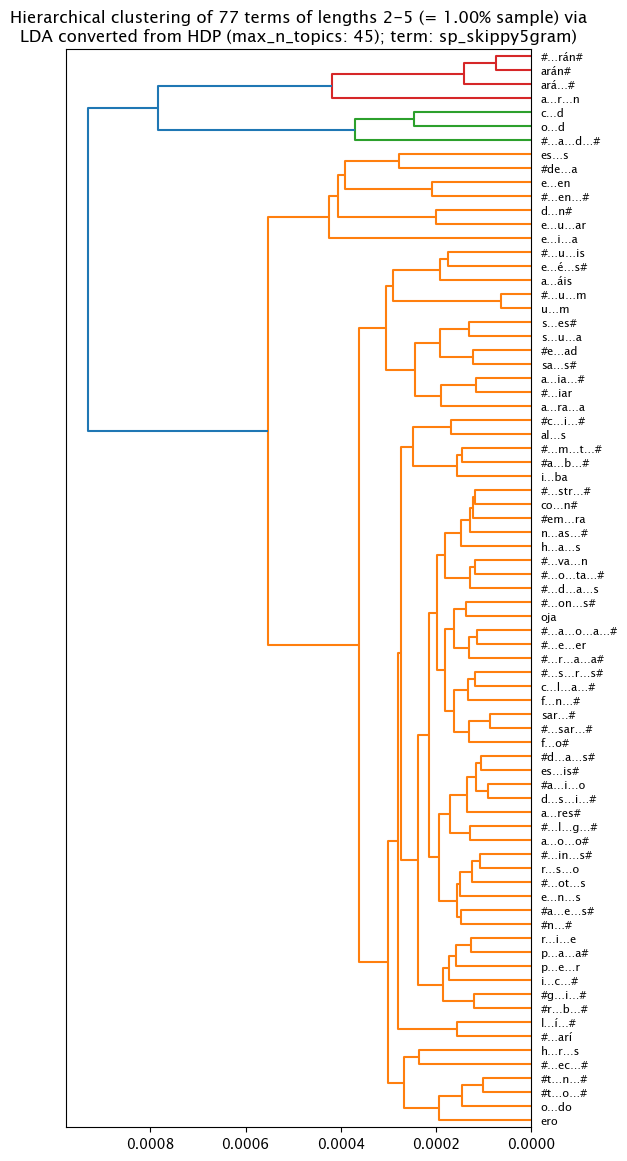

In [505]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp45, diction, n_topics = 45, lowest_density = 0.0006, gap_mark = gap_mark, min_length = 2, sampling_rate = hc_sampling_rate, check = False)

In [506]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [507]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [508]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [509]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * #…e…s…# + 0.0 * #s…s + 0.0 * #s…a + 0.0 * s…e…s + 0.0 * e…e…s + 0.0 * s…as + 0.0 * #…b…a + 0.0 * #s…e + 0.0 * s…is + 0.0 * #…e…os + 0.0 * s…a…s# + 0.0 * s…a…s + 0.0 * #…s…n + 0.0 * #…s…e…# + 0.0 * o…e…s + 0.0 * #s…a…# + 0.0 * r…e# + 0.0 * s…is# + 0.0 * a…ra…# + 0.0 * #…se…#
nonzero count:  349
	0.9988: #aristados#
	0.9988: #manqueado#
	0.9988: #agarraras#
	0.9987: #parrandas#
	0.9987: #abrasando#
	0.9987: #serpeadas#
	0.9987: #semaneros#
	0.9986: #desviasen#
	0.9986: #sonrieras#
	0.9986: #cableaste#
	0.9986: #miniaseis#
	0.9985: #punisteis#
	0.9985: #mandantes#
	0.9984: #golpistas#
	0.9984: #sacristas#
topic_id 1: 0.0 * #…a…l + 0.0 * #…a…l…# + 0.0 * o…o…# + 0.0 * #…o…o…# + 0.0 * a…o…a + 0.0 * #en…a + 0.0 * t…l…# + 0.0 * t…l + 0.0 * lo + 0.0 * #c…r + 0.0 * o…l…# + 0.0 * o…l + 0.0 * #c…r…# + 0.0 * a…o…a…# + 0.0 * #…lo + 0.0 * c…l + 0.0 * c…l…# + 0.0 * #t…a + 0.0 * en…a…# + 0.0 * c…d
nonzero count:  341
	0.9988: #piloteará#
	0.9987: #coloreada#
	0.9987: #titiladas#
	0.99

6560 rows remain after density filtering, discarding 93440 rows
6553 rows remain after size filtering, discarding 7 rows
66 rows remain after size filtering, discarding 6487 rows


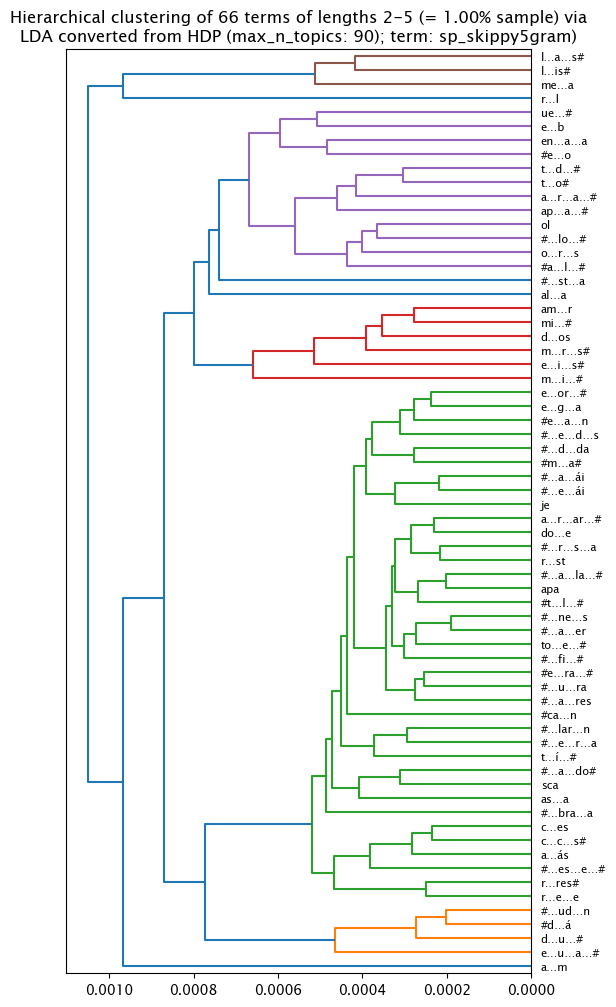

In [510]:
## term の階層クラスタリング: max_n_topics, term の値に拠ってparameters の最適値は異なる
hc_clustering_terms_from_hdp(hdp90, diction, n_topics = 90, gap_mark = gap_mark, lowest_density = 0.0012, min_length = 2, sampling_rate = hc_sampling_rate, check = False)